<div class="alert alert-warning">
This is an exercise to be handed in on Peergrade
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp "drive/My Drive/Colab Notebooks/Deep Learning/plotting.py" .

Mounted at /content/drive


In [1]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

# Practice: Building and Training VAEs


In [3]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        self.size0 = mu.size(0)
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu+torch.mul(self.sample_epsilon(),self.sigma)
        #raise NotImplementedError # <- your code
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        dist=torch.distributions.Normal(loc=self.mu,scale=self.sigma)
        return dist.log_prob(z)
        #raise NotImplementedError # <- your code


## Dataset: MNIST

First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through the `classes` variable, to speed up training.

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
from functools import reduce


from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

flatten = lambda x: ToTensor()(x).view(28**2)

dset_train = MNIST(root='./', train=True,download=True, transform=flatten)
dset_test = MNIST(root='./', train=False,download=False, transform=flatten)


classes=[0, 1, 4, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


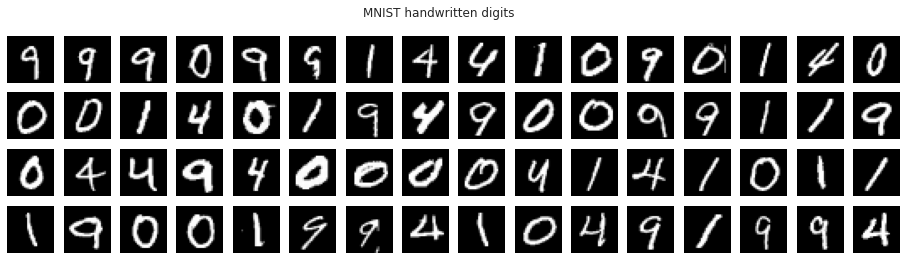

In [6]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

## Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [7]:
class BaseVAEprob(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, latent_features:int, encoder, decoder, beta=1) -> None:
        super(BaseVAEprob, self).__init__()
        
        self.latent_features = latent_features
        self.beta=beta

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = encoder
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        # mu, sigma        
        self.decoder = decoder
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        z_tmp = self.decoder(z)
        mu, log_sigma =  z_tmp.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = self.forward(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = px.log_prob(x).view(px.size0, -1).sum(dim=1)
        log_pz = pz.log_prob(z).view(pz.size0, -1).sum(dim=1)
        log_qz = qz.log_prob(z).view(qz.size0, -1).sum(dim=1)
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`

        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs


In [10]:
latent_features = 24
observation_features = np.prod(images[0].shape)
enc = nn.Sequential(
            nn.Linear(in_features=observation_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
# Generative Model
# Decode the latent sample `z` into the parameters of the observation model
# `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
dec = nn.Sequential(
    nn.Linear(in_features=latent_features, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=2*observation_features)
)
vae = BaseVAEprob( latent_features=latent_features,encoder=enc,decoder=dec)
print(vae)

BaseVAEprob(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=48, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1568, bias=True)
  )
)


## Training and Evaluation

### Initialize the model, evaluator and optimizer

In [11]:
from collections import defaultdict
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

>> Using device: cuda:0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


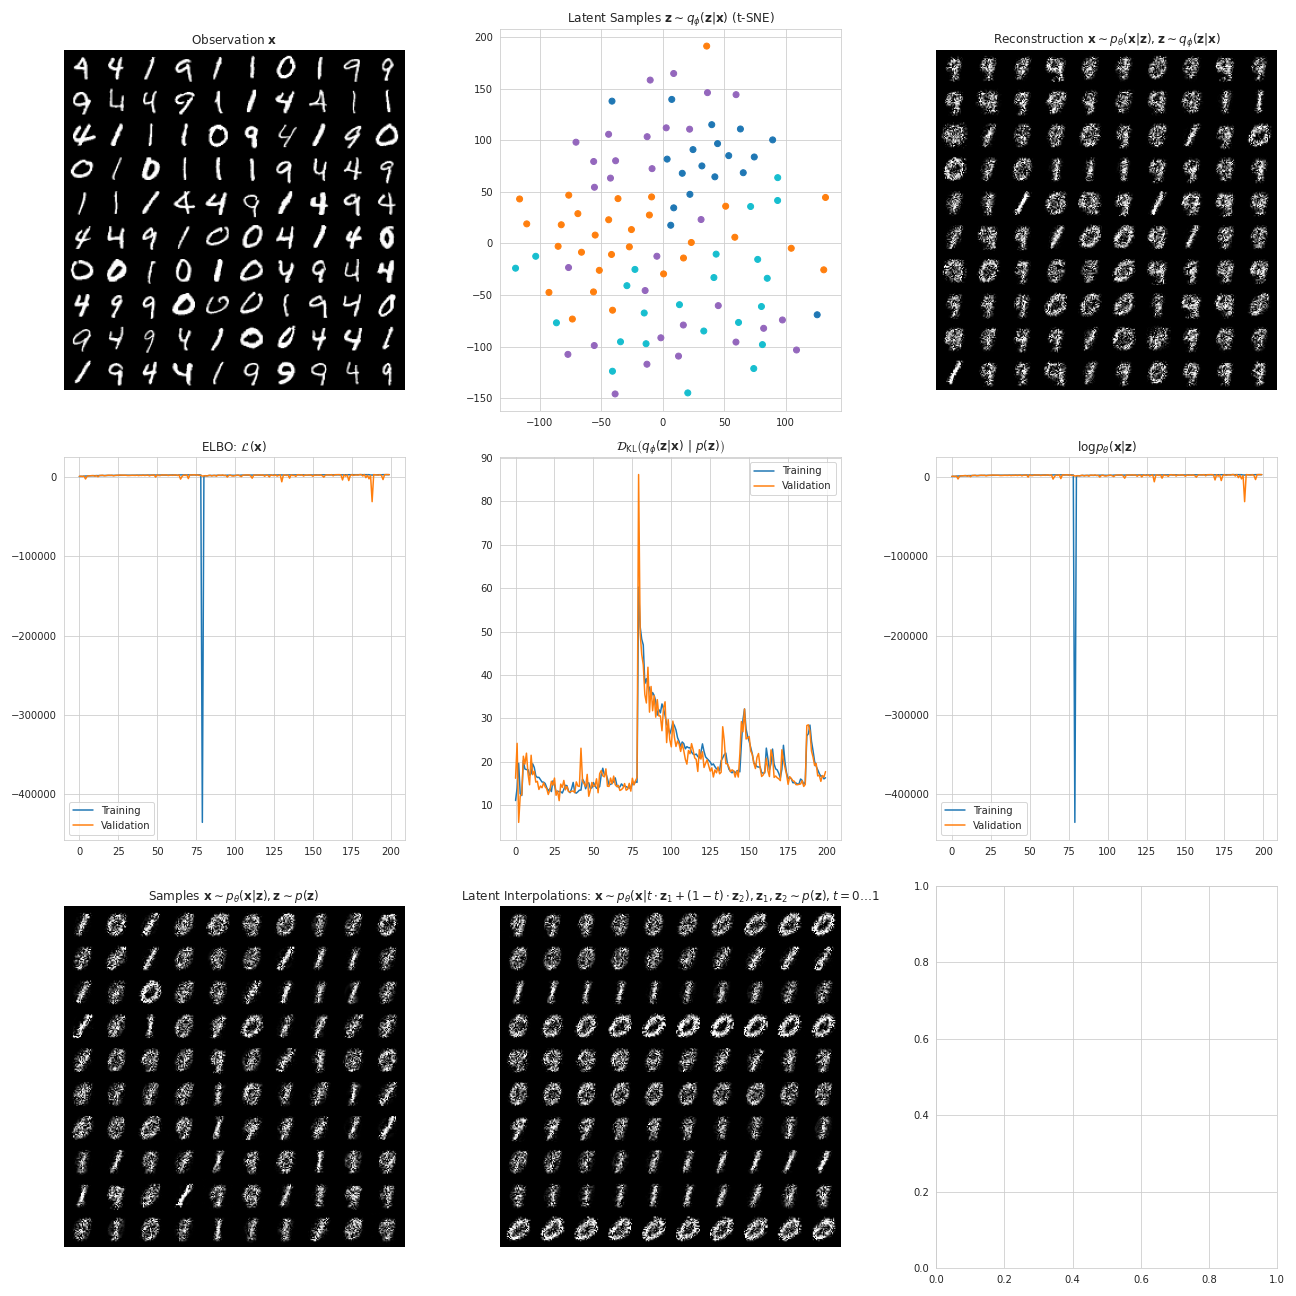

In [12]:
num_epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    print(epoch)
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vae.elbo(x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vae.elbo(x)
      
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
# Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
make_vae_plots(vae, x, y, outputs, training_data, validation_data)